# QLanczos

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import eigh
from scipy.linalg import eig
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
# import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

Calculate normalization coefficients using recurrence in 

In [2]:
def normalization_coefficient(ncoefs,Ccoefs,r):
    """
    Compute the rth normalization coefficient via recurrence
    """
    nr=ncoefs[r-1]
    Cr=Ccoefs[r-1]
    return nr/np.sqrt(Cr)

def normalization_coefficients(Ccoef):
    """
    Compute normalization coefficients from overlaps 
    """
    ncoefs=np.zeros(len(Ccoef))
    ncoefs[0]=1/np.sqrt(Ccoef[0])
    for r in range(1,len(Ccoef)):
        ncoefs[r]=normalization_coefficient(ncoefs,Ccoef,r)
    
    return ncoefs


QLanczos 

In [67]:
def Krylov_matrices(krylov_indices,ncoefs,energies,threshold=1e-2):
    dim=len(krylov_indices)
    
    ## Construct overlap matrix
    T=np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            T[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

    ## Elimiate small eigenvalues form overlap matrix
    eigs,evecs=eig(T)
    print(eigs)
    D=np.zeros((dim,dim))
    for i in range(dim):
        if abs(eigs[i].real)>threshold:
            D[i,i]=eigs[i]
    
    T=np.dot(evecs.transpose(),np.dot(D,evecs))  
            
    ## Construct H matrix 
    H=np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            H[i,j]=T[i,j]*energies[k]
            
    return T,H



def run_qlanczos_experiment(H,krylov_dim,delta_time,backend,initialization,max_iterations=100,krylov_threshold=.99999,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
    n_shots=10000 ## Set to allowed number of shots at IBMQ

    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=sigma_terms(n_qubits)

    ## Construct b in terms of paulis 
    b_pauli_terms=b_terms(H,sigmas)
    
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get composite set of pauli terms that need to be calculated for QITE 
    pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

    ## Get commuting set 
    commuting_sets=get_commuting_sets(sorted(pauli_set))
    
    ## Zero initialize 
    A_set=[]
    a=np.zeros(len(sigmas))
    Energies=[]
    Ccoefs=[]
    ncoefs=[]
    
    ## for each time step, run circuit and compute A for the next time step
    krylov_indices=[0]
    t=0
    while len(krylov_indices)<krylov_dim:
        if t>max_iterations:
            break
        expectation_values={}
        if backend=='statevector_simulator':
            ## Run circuit to get state vector
            psi=run_circuit_statevector(n_qubits,A_set,delta_time,initialization=None)

            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value

        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,delta_time,n_shots=n_shots,initialization=None)

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        energy=0.0
        for key in H_pauli:
            energy+=H_pauli[key]*expectation_values[key]

        Energies.append(energy.real)

        ## compute normalization coef C=1-2*E*delta_times
        Ccoef=1-2*delta_time*Energies[t]
        Ccoefs.append(Ccoef)
        
        ## Compute A
        A_set.append(A_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,Ccoef,A_threshold))

        if isinstance(cstep,int):
            if t%cstep==0:
                identity_string="I"*n_qubits
                A_combine=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
                for A in A_set:
                    A_combine+=A
                A_set=[A_combine]
         
        ### Compute normalization factor 
        if t==0:
            ncoefs.append(1.0)
        else:
            ncoefs.append(normalization_coefficient(ncoefs,Ccoefs,t))
            
            ## If even time step, check overlap
            if t%2==0:        
                i=t
                j=krylov_indices[-1]
                k=int((i+j)/2)
                regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
                if regularization_factor<krylov_threshold:
                    krylov_indices.append(i)
        
        ### increment t
        t+=1    

    ## Construct krylove matries 
    T_krylov,H_krylov=Krylov_matrices(krylov_indices,ncoefs,Energies,threshold=.5)

    ## Solve generalized eigenproblem
    eigs,vecs=eig(H_krylov,T_krylov)
#     print(eigs.real)
    idx = eigs.argsort()[0]
#     print(idx)
#     print(f"Iterations: {t-1}")
#     print(f"Krylov dim: {len(krylov_indices)}")
    return eigs[idx].real


def eliminate_outliers(energies):
    mean=np.mean(energies)
    sd=np.std(energies)
    survivors=[]
    for e in energies:
        if abs(e)<=(abs(mean)+2*sd):
            survivors.append(e)
        else:
            print(f"{e:.5f} killed")
    return survivors

In [68]:
H = hamiltonian_matrix(Nmax=6,J=1,interaction="toy")
exact_eigenvalue,_=eigh(H)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(f"N qubits: {n_qubits}")

initialization="single_state"
backend = 'statevector_simulator'

# krylov_dim=8
# kthreshold=.998

krylov_dim=7
kthreshold=.999

max_itr=100
delta_time=0.01
QL_energy=run_qlanczos_experiment(H_qubit,krylov_dim,delta_time,backend,initialization,max_iterations=max_itr,krylov_threshold=kthreshold,A_threshold=1e-10,cstep=1)
# print(QL_energies)

N qubits: 2
[ 6.90031798e+00+0.j  9.78218276e-02+0.j  1.84656122e-03+0.j
  1.45231221e-05+0.j -8.89996406e-07+0.j -1.83253655e-09+0.j
 -1.71962491e-11+0.j]


In [69]:
time_steps=20
Qite_energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-10,cstep=1)
print(f"Exact eigenvalue: {exact_eigenvalue[0]:0.6}")
print(f"Qite eigenvalue: {Qite_energies[-1]:0.6}")
print(f"QLancozs eigenvalue: {QL_energy:0.6}")

100%|██████████| 20/20 [00:00<00:00, 79.09it/s]

Exact eigenvalue: -2.14398
Qite eigenvalue: -2.08738
QLancozs eigenvalue: -2.14395


In [70]:
Nmax=6
H = hamiltonian_matrix(Nmax,J=1,interaction="toy")
exact_eigenvalue,_=eigh(H)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(f"N qubits: {n_qubits}")

initialization="zeros"
backend = 'qasm_simulator'

# krylov_dim=8
# kthreshold=.998

max_itr=20
krylov_dim=20
kthreshold=.99999


delta_time=0.01
energies=[]
for i in tqdm(range(10)):
    QL_energy=run_qlanczos_experiment(H_qubit,krylov_dim,delta_time,backend,initialization,max_iterations=max_itr,krylov_threshold=kthreshold,A_threshold=1e-2,cstep=1)
    energies.append(QL_energy)
#     print(QL_energy)
print(energies)

  0%|          | 0/10 [00:00<?, ?it/s]

N qubits: 2


 10%|█         | 1/10 [00:05<00:46,  5.21s/it]

[ 8.87866942e+00+0.j  1.16618263e-01+0.j  7.11388682e-03+0.j
  4.47665720e-03+0.j -5.07565262e-03+0.j -3.18868802e-03+0.j
  1.73983527e-03+0.j  2.90373730e-04+0.j -6.44092055e-04+0.j]


 20%|██        | 2/10 [00:10<00:41,  5.22s/it]

[ 7.87891491e+00+0.j  1.20102366e-01+0.j -8.27674399e-03+0.j
  7.87869704e-03+0.j -2.73839364e-03+0.j  3.00027770e-03+0.j
  7.17206753e-04+0.j  4.01682866e-04+0.j]


 30%|███       | 3/10 [00:15<00:36,  5.24s/it]

[ 7.90712800e+00+0.j  9.59339380e-02+0.j -1.03489802e-02+0.j
  5.78159214e-03+0.j -1.81095119e-03+0.j  2.27549374e-03+0.j
 -1.90683181e-05+0.j  1.05997983e-03+0.j]


 40%|████      | 4/10 [00:21<00:31,  5.28s/it]

[ 6.90625418e+00+0.j  9.59592726e-02+0.j -1.09396747e-02+0.j
  8.41403629e-03+0.j  2.30964937e-03+0.j -1.79048596e-03+0.j
 -2.06976702e-04+0.j]


 50%|█████     | 5/10 [00:26<00:26,  5.28s/it]

[ 8.89638253e+00+0.j  9.50920483e-02+0.j -1.20245484e-02+0.j
  1.39729833e-02+0.j -3.71234614e-03+0.j -3.69127003e-04+0.j
  1.50033622e-03+0.j  4.06305362e-03+0.j  5.09506850e-03+0.j]


 60%|██████    | 6/10 [00:31<00:21,  5.29s/it]

[ 8.87435589e+00+0.j  1.25797176e-01+0.j -6.71101972e-03+0.j
 -2.93060619e-03+0.j -1.26380438e-03+0.j -2.35615418e-04+0.j
  5.01132934e-03+0.j  2.11834129e-03+0.j  3.85830687e-03+0.j]


 70%|███████   | 7/10 [00:36<00:15,  5.29s/it]

[ 1.08621089e+01+0.j  1.27803024e-01+0.j  7.10384270e-03+0.j
 -4.60283047e-03+0.j -2.28949170e-03+0.j -1.31301589e-03+0.j
 -6.48997404e-04+0.j  4.47968580e-03+0.j  1.27278455e-03+0.j
  2.64830104e-03+0.j  3.43776543e-03+0.j]


 80%|████████  | 8/10 [00:42<00:10,  5.30s/it]

[ 7.91007593e+00+0.j  9.45021674e-02+0.j -8.74831272e-03+0.j
 -1.80700724e-03+0.j -1.19264053e-03+0.j  3.48367851e-03+0.j
  1.11898016e-03+0.j  2.56720094e-03+0.j]


 90%|█████████ | 9/10 [00:47<00:05,  5.29s/it]

[ 6.89297695e+00+0.j  1.01971813e-01+0.j  9.40819677e-03+0.j
  3.38545700e-03+0.j -4.66626077e-03+0.j -1.82086914e-03+0.j
 -1.25528547e-03+0.j]


100%|██████████| 10/10 [00:52<00:00,  5.29s/it]

[ 7.91026556e+00+0.j  8.59616066e-02+0.j  6.64145337e-03+0.j
 -6.06464452e-03+0.j -2.38835735e-03+0.j  2.93274065e-03+0.j
  1.62986588e-03+0.j  1.02177151e-03+0.j]
[-2.082863155480637, -2.198327910523626, -2.550908997391437, -2.4123346685724836, -2.0500364454438365, -2.0699219651662237, -2.109389723445415, -1.9323809507927392, -4.100717578782397, -2.083670748103141]


In [71]:
e_mean=np.mean(energies)
sd=np.std(energies)
print(e_mean,sd)

survivors=eliminate_outliers(energies)
print(np.mean(survivors))

-2.3590552143701937 0.6061733011002934
-4.10072 killed
-2.165537173879949


In [61]:
time_steps=40
Qite_energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-2,cstep=1)
print(f"Exact eigenvalue: {exact_eigenvalue[0]:0.6}")
print(f"Qite eigenvalue: {Qite_energies[-1]:0.6}")
print(f"QLancozs eigenvalue: {QL_energy:0.6}")

100%|██████████| 40/40 [00:10<00:00,  3.98it/s]

Exact eigenvalue: -2.14398
Qite eigenvalue: -2.20641
QLancozs eigenvalue: -2.08481


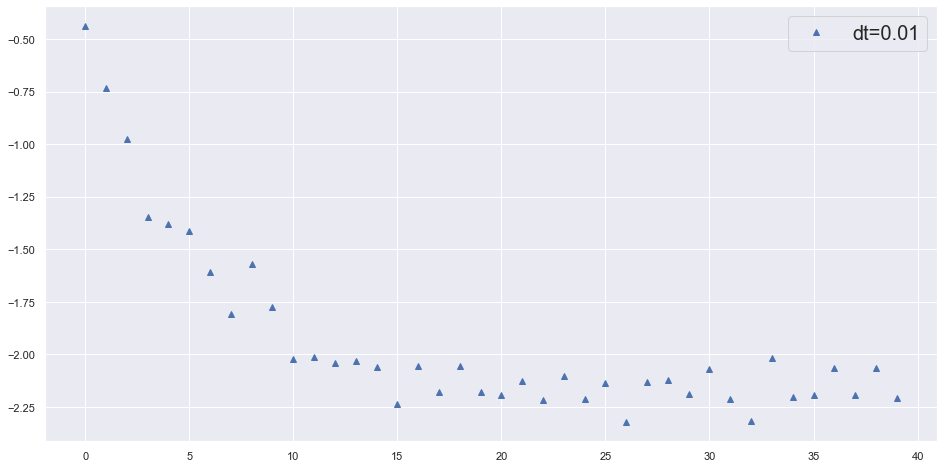

In [62]:
time=[t for t in range(time_steps)]
plt.plot(time,Qite_energies,'b^',label="dt=0.01")
plt.legend(prop={'size': 20})